In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import time
import timeit
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Flatten
from keras.datasets import mnist
from keras.models import Sequential
from sklearn.preprocessing import normalize
from tensorflow.keras.optimizers import SGD
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import ZeroPadding1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten,GRU

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-xxp7uhl1
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-xxp7uhl1
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=b1adfd6d8df8191e0cc157f76415c3bde2da8f9e7841f171ad743821d1b53598
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgrlzzoj/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

Tensorflow/Keras: 2.8.0
pandas: 1.3.5
numpy: 1.21.6
sklearn: 1.0.2
plotly: 5.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    meta = []
    with open("/content/drive/My Drive/GRU/DATA/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/GRU/DATA/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/GRU/DATA/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/GRU/80_20/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/GRU/80_20/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/GRU/80_20/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/GRU/80_20/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 70) (46848, 4)
testing dataset: (11712, 70) (11712, 4)


In [ ]:

with open('/content/drive/My Drive/GRU/80_20/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/GRU/80_20/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

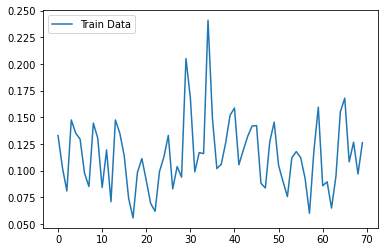

In [ ]:
plt.plot(X[window_size])
plt.legend(['Train Data'], loc='upper left')

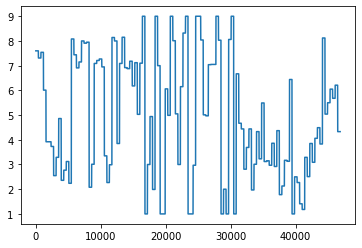

In [ ]:
plt.plot(Valence_Train)

In [ ]:
X.shape

(46848, 70)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape

(46848, 10)

In [ ]:
x_train = np.array(X[:])

In [ ]:

with open('/content/drive/My Drive/LEADING_AI/70_30/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/LEADING_AI/70_30/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(46848, 70, 1)

In [ ]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(70, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense,GRU,LSTM
from keras.regularizers import l2

In [ ]:
from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf

In [ ]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(Conv1D(128, 3,  activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 68, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 34, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0

In [ ]:
model_2.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
history_2 = model_2.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
183/183 [==============================] - 75s 386ms/step - loss: 1.6493 - accuracy: 0.2963 - val_loss: 1.5275 - val_accuracy: 0.3324
Epoch 2/200
183/183 [==============================] - 68s 370ms/step - loss: 1.5418 - accuracy: 0.3306 - val_loss: 1.4853 - val_accuracy: 0.3719
Epoch 3/200
183/183 [==============================] - 65s 358ms/step - loss: 1.4852 - accuracy: 0.3614 - val_loss: 1.4146 - val_accuracy: 0.4018
Epoch 4/200
183/183 [==============================] - 69s 375ms/step - loss: 1.4261 - accuracy: 0.3983 - val_loss: 1.3560 - val_accuracy: 0.4307
Epoch 5/200
183/183 [==============================] - 65s 357ms/step - loss: 1.3747 - accuracy: 0.4229 - val_loss: 1.2942 - val_accuracy: 0.4570
Epoch 6/200
183/183 [==============================] - 69s 379ms/step - loss: 1.3242 - accuracy: 0.4456 - val_loss: 1.2390 - val_accuracy: 0.4877
Epoch 7/200
183/183 [==============================] - 66s 359ms/step - loss: 1.2722 - accuracy: 0.4698 - val_loss: 1.1646 -

In [ ]:
score_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

458/458 [==============================] - 11s 24ms/step - loss: 0.1148 - accuracy: 0.9654
Test loss: 0.1147860586643219
Test accuracy: 0.9654371738433838


In [ ]:
model_2.save('C:\\gru_model.h5')
np.save('C:\\gru_model.npy', history_2.history)

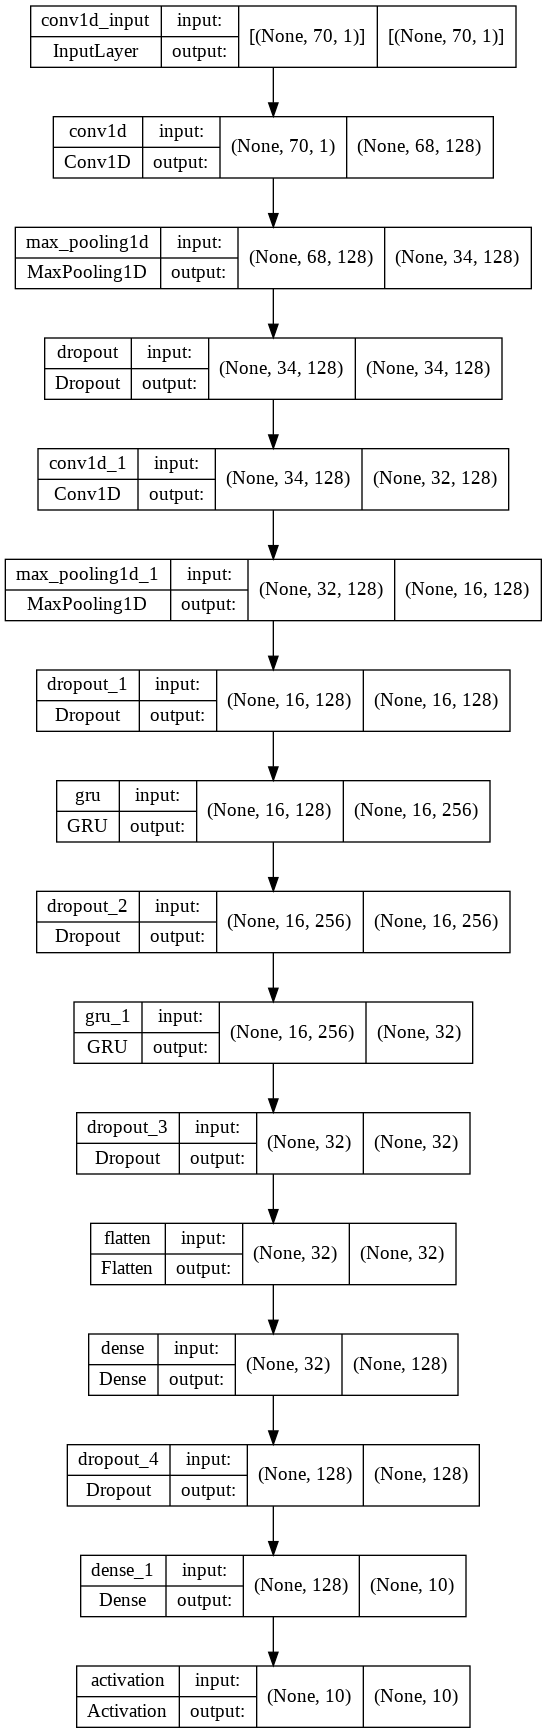

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, to_file='/content/drive/My Drive/GRU/GRU.png', show_shapes = True)

In [ ]:
# list all data in history
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


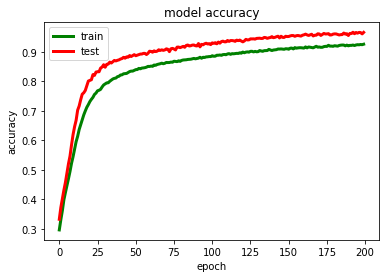

'\nimport matplotlib.pyplot as plt\nprint(m.history.keys())\n# summarize history for accuracy\nplt.plot(m.history[\'accuracy\'],color=\'green\',linewidth=3.0)\nplt.plot(m.history[\'val_accuracy\'],color=\'red\',linewidth=3.0)\n\nplt.title(\'model accuracy\')\nplt.ylabel(\'accuracy\')\nplt.xlabel(\'epoch\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\n\nplt.savefig("/content/drive/My Drive/GRU/model accuracy.png")\nplt.show()'

In [ ]:
# summarize history for accuracy
plt.plot(history_2.history['accuracy'],color='green',linewidth=3.0)
plt.plot(history_2.history['val_accuracy'],color='red',linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("/content/drive/My Drive/GRU/model accuracy.png")
plt.show()

'''
import matplotlib.pyplot as plt
print(m.history.keys())
# summarize history for accuracy
plt.plot(m.history['accuracy'],color='green',linewidth=3.0)
plt.plot(m.history['val_accuracy'],color='red',linewidth=3.0)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("/content/drive/My Drive/GRU/model accuracy.png")
plt.show()'''

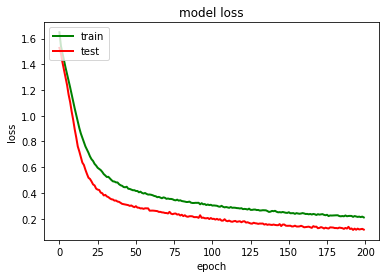

' # summarize history for loss\nimport imageio\nplt.plot(m.history[\'loss\'],color=\'green\',linewidth=2.0)\nplt.plot(m.history[\'val_loss\'],color=\'red\',linewidth=2.0)\n\nplt.title(\'model loss\')\nplt.ylabel(\'loss\')\nplt.xlabel(\'epoch\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\n\n#to save the image\nplt.savefig("/content/drive/My Drive/Bi- LSTM/model loss.png")\nplt.show()\n'

In [ ]:
# summarize history for loss
plt.plot(history_2.history['loss'],color='green',linewidth=2.0)
plt.plot(history_2.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("/content/drive/My Drive/GRU/model loss.png")
plt.show()

''' # summarize history for loss
import imageio
plt.plot(m.history['loss'],color='green',linewidth=2.0)
plt.plot(m.history['val_loss'],color='red',linewidth=2.0)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#to save the image
plt.savefig("/content/drive/My Drive/Bi- LSTM/model loss.png")
plt.show()
'''

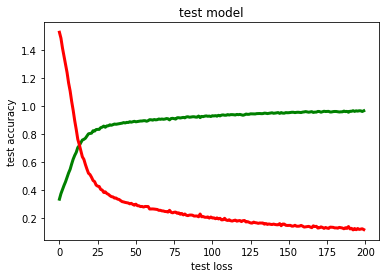

'\nplt.plot(m.history[\'val_accuracy\'],color=\'green\',linewidth=3.0)\nplt.plot(m.history[\'val_loss\'],color=\'red\',linewidth=3.0)\nplt.title(\'test model\')\nplt.ylabel(\'test accuracy\')\nplt.xlabel(\'test loss\')\n\nplt.legend()\nplt.savefig("/content/drive/My Drive/Bi- LSTM/Test model.png")\nplt.show()\n'

In [ ]:
plt.plot(history_2.history['val_accuracy'],color='green',linewidth=3.0)
plt.plot(history_2.history['val_loss'],color='red',linewidth=3.0)
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')

plt.savefig("/content/drive/My Drive/GRU/Test model.png")
plt.show()

'''
plt.plot(m.history['val_accuracy'],color='green',linewidth=3.0)
plt.plot(m.history['val_loss'],color='red',linewidth=3.0)
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')

plt.legend()
plt.savefig("/content/drive/My Drive/Bi- LSTM/Test model.png")
plt.show()
'''

In [ ]:
M=history_2

In [ ]:
y_pred=model_2.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
y_pred[1]

array([9.0718830e-29, 5.4921556e-09, 1.3392608e-27, 2.7248457e-06,
       1.6102966e-10, 1.1900286e-05, 5.4464367e-06, 9.9996006e-01,
       1.9742389e-05, 1.2805889e-08], dtype=float32)

In [ ]:
y_test1=np.argmax(y_test, axis=1)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_test1[1]

7

In [ ]:
y_pred[1]

7

In [ ]:
cmatrix=confusion_matrix(y_test1, y_pred)

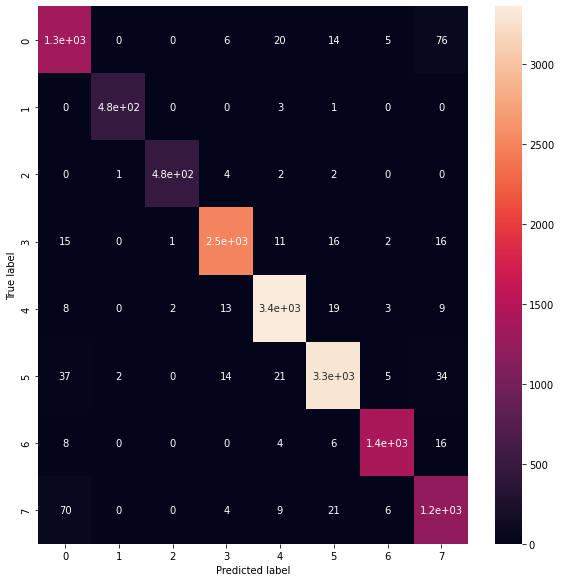

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True) #,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig("/content/drive/My Drive/GRU/lstmconfusion matrix.png")
plt.show()

In [ ]:
from sklearn import metrics
y_pred = np.around(model_2.predict(x_test))

#plt.savefig("/content/drive/My Drive/GRU/classificationreport.png")
print(metrics.classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.94      0.88      0.91      1464
           2       0.00      0.00      0.00         0
           3       0.99      0.99      0.99       488
           4       0.99      0.98      0.99       488
           5       0.99      0.97      0.98      2562
           6       0.99      0.98      0.98      3416
           7       0.98      0.96      0.97      3416
           8       0.99      0.97      0.98      1464
           9       0.92      0.89      0.91      1342

   micro avg       0.98      0.96      0.97     14640
   macro avg       0.78      0.76      0.77     14640
weighted avg       0.98      0.96      0.97     14640
 samples avg       0.96      0.96      0.96     14640

